In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import h5py
import tifffile

In [2]:
# time interval of the movie in minutes
time_interval = 2

# Path to the -spots.csv 
path_csv = 'H:PROJECTS-03/Feyza/250130-LoopingxUtrCh+H2BiRFP+memCer(mosaic)/20250130_164010_Experiment/Spot.csv' 

# Path to .xml file generated when creating the .hdf5
path_xml = 'H:PROJECTS-03/Feyza/250130-LoopingxUtrCh+H2BiRFP+memCer(mosaic)/20250130_164010_Experiment/pos6.xml' # Path to .xml file

# Path to .hs file generated when creating the xml/hdf5 
path_hdf5 = 'H:PROJECTS-03/Feyza/250130-LoopingxUtrCh+H2BiRFP+memCer(mosaic)/20250130_164010_Experiment/pos6.h5'

In [3]:
# Obtain all the features that are in the .xml file which has been generated when the data
# is converted to .hdf5 using BigDataViewer/BigStitcher/MultiviewReconstruction in Fiji
import untangle
class xml_features:
    def __init__(self, path_xml):
        # Parse .xml file
        obj = untangle.parse(path_xml)
        # Data Features
        try:
            self.channels = len(obj.SpimData.SequenceDescription.ViewSetups.Attributes[1])
        except:
            self.channels = len(obj.SpimData.SequenceDescription.ViewSetups.Attributes.Channel)
        ch = self.channels
        self.dim = 3
        
        if ch > 1:
            self.width = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[0])
            self.height = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[1])
            self.n_slices = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].size.cdata.split()[2])

            self.x_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[0])
            self.y_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[1])
            self.z_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.size.cdata.split()[2])
            
            self.units = obj.SpimData.SequenceDescription.ViewSetups.ViewSetup[0].voxelSize.unit.cdata
        else:
            self.width = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.size.cdata.split()[0])
            self.height = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.size.cdata.split()[1])
            self.n_slices = int(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.size.cdata.split()[2])

            self.x_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.voxelSize.size.cdata.split()[0])
            self.y_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.voxelSize.size.cdata.split()[1])
            self.z_pixel = float(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.voxelSize.size.cdata.split()[2])
            
            self.units = obj.SpimData.SequenceDescription.ViewSetups.ViewSetup.voxelSize.unit.cdata
            

        #self.channels = len(obj.SpimData.SequenceDescription.ViewSetups.ViewSetup)
      
        while True:
            try:
                self.n_frames = len(obj.SpimData.SequenceDescription.Timepoints.integerpattern.cdata.split())
                break
            except AttributeError:
                pass  # fallback to dict
            try:
                self.n_frames = int(obj.SpimData.SequenceDescription.Timepoints.last.cdata.split()[0])
                break
            except KeyError:
                raise AttributeError("There is something wrong with the .xml file - Did you compute the features?") from None
fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2304, 2304, 201, 4
There are 219 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 0.5 micron
There are 201 Z-slices in total


#### Import Mastodon Output

In [4]:
# Load the CSV file
df = pd.read_csv(path_csv, skiprows=[1, 2])

# Column names for various features
track_column = 'Spot track ID'       # Track ID column
time_column = 'Spot frame'           # Frame (time step) column
time_column_corrected = 'Time in min'
position_x_column = 'Spot position'  # X position column
position_y_column = 'Spot position.1'  # Y position column
position_z_column = 'Spot position.2'  # Z position column

# Convert relevant columns to numeric types
columns_to_convert = [track_column, time_column, position_x_column, position_y_column, position_z_column]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# Create a new column for corrected time
df[time_column_corrected] = df[time_column] * time_interval

# Drop rows with NaN values in the critical columns
df.dropna(subset=[track_column, time_column, time_column_corrected, position_x_column, position_y_column, position_z_column], inplace=True)

# Ensure the DataFrame is sorted by track ID and corrected time
df = df.sort_values(by=[track_column, time_column_corrected])

#### Plot all track positions

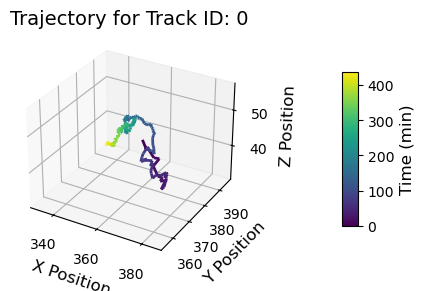

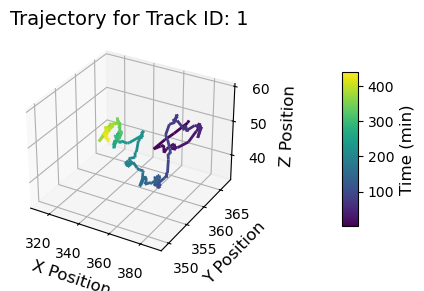

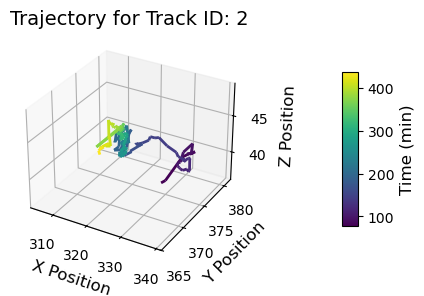

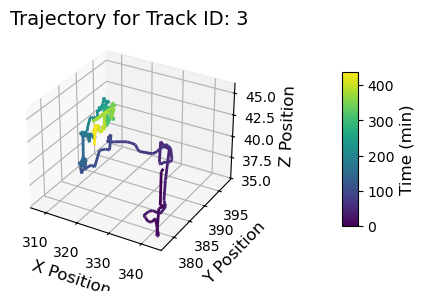

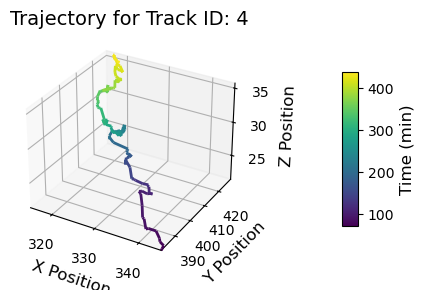

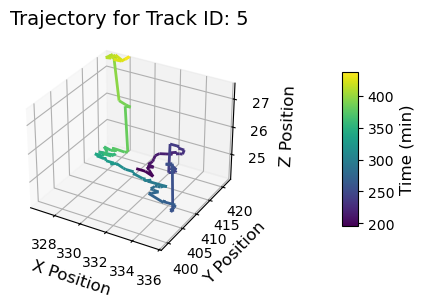

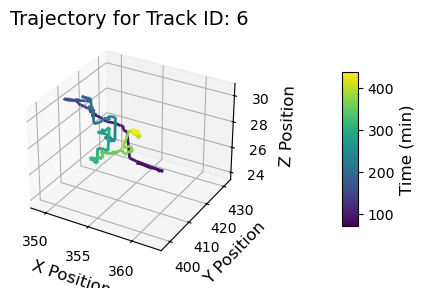

In [5]:
# Group the data by track ID
grouped = df.groupby(track_column)

# Iterate through each group and create a 3D plot
for track_id, group in grouped:
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Extract the data for the current group
    x = group[position_x_column].values
    y = group[position_y_column].values
    z = group[position_z_column].values
    time = group[time_column_corrected].values

    # Normalize the time for colormap
    norm = mcolors.Normalize(vmin=time.min(), vmax=time.max())
    cmap = cm.viridis  # Choose your colormap
    colors = cmap(norm(time))

    # Create line segments for colormapping
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a Line3DCollection
    lc = Line3DCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(time)
    lc.set_linewidth(2)
    ax.add_collection(lc)

    # Set the limits for the axes
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_zlim(z.min(), z.max())

    # Add a colorbar
    cbar = fig.colorbar(lc, ax=ax, shrink=0.5, aspect=10, pad=0.25)
    cbar.set_label('Time (min)', fontsize=12)

    # Label axes
    ax.set_title(f'Trajectory for Track ID: {track_id}', fontsize=14)
    ax.set_xlabel('X Position', fontsize=12)
    ax.set_ylabel('Y Position', fontsize=12)
    ax.set_zlabel('Z Position', fontsize=12)

    # Show the plot
    plt.show()


In [ ]:
# interactive 3d plots
import plotly.graph_objects as go

# Iterate through groups and create interactive 3D plots
for track_id, group in grouped:
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=group[position_x_column],
        y=group[position_y_column],
        z=group[position_z_column],
        mode='lines+markers',
        name=f'Track ID: {track_id}'
    ))

    # Set titles and axis labels
    fig.update_layout(
        title=f'Trajectory for Track ID: {track_id}',
        scene=dict(
            xaxis_title='X Position',
            yaxis_title='Y Position',
            zaxis_title='Z Position'
        )
    )

    # Show the plot
    fig.show()

### Crop ROI around tracks

#### rearrange the data 

In [65]:
# Count the number of unique tracks (cells)
n_cells = df[track_column].nunique()

# Initialize matrices to store tracked cell data at each time point (with an additional frame)
tracks_save = np.ones((n_cells, fts.n_frames + 1)) * np.nan
x_save = np.ones((n_cells, fts.n_frames + 1)) * np.nan
y_save = np.ones((n_cells, fts.n_frames + 1)) * np.nan
z_save = np.ones((n_cells, fts.n_frames + 1)) * np.nan

# For each track (unique track_id)
for i, track_id in enumerate(df[track_column].unique()):
    # Find the rows corresponding to the current track_id
    track_data = df[df[track_column] == track_id]
    
    # For each time frame for the current track
    for _, row in track_data.iterrows():
        # Get the time and frame values
        time = row[time_column]  # This will be the time frame 
        
        # Ensure time is an integer (round or cast to int)
        time = int(time)  # Cast the time to integer if necessary
        
        # Adjust time to zero-based indexing by subtracting 1
        time_index = time
        
        # Check if time_index is within the (fts.n_frames + 1)
        if 0 <= time_index < fts.n_frames + 1:
            # Store the tracked data at the corresponding position
            tracks_save[i, time_index] = track_id
            x_save[i, time_index] = row[position_x_column]
            y_save[i, time_index] = row[position_y_column]
            z_save[i, time_index] = row[position_z_column]


#### apply transformation to reverse registration (needs to be tested)

In [9]:
import numpy as np
import untangle

# Count the number of unique tracks (cells)
n_cells = df[track_column].nunique()

# Parse the XML file
obj = untangle.parse(path_xml)

# Initialize matrices to store transformed tracked cell data
tracks_save = np.ones((n_cells, fts.n_frames + 1)) * np.nan
x_save_r = np.ones((n_cells, fts.n_frames + 1)) * np.nan
y_save_r = np.ones((n_cells, fts.n_frames + 1)) * np.nan
z_save_r = np.ones((n_cells, fts.n_frames + 1)) * np.nan
transformation_status = np.empty((n_cells, fts.n_frames + 1), dtype=object)

# For each track (unique track_id)
for i, track_id in enumerate(df[track_column].unique()):
    # Find the rows corresponding to the current track_id
    track_data = df[df[track_column] == track_id]
    
    # For each time frame for the current track
    for _, row in track_data.iterrows():
        time = int(row[time_column])  # Ensure time is integer
        time_index = time  # Zero-based indexing
        
        if 0 <= time_index < fts.n_frames + 1:
            # Store the track ID
            tracks_save[i, time_index] = track_id
            
            # Extract original coordinates
            xyz_coord = np.array([
                row[position_x_column],
                row[position_y_column],
                row[position_z_column]
            ]).reshape(-1, 1)
            
            try:
                # Retrieve registration data for the current frame
                registration = obj.SpimData.ViewRegistrations.ViewRegistration[time_index]
                
                if registration is None or not registration.ViewTransform[0].affine.cdata.strip():
                    # Use identity transformation if affine data is missing
                    print(f"Warning: Missing affine data for index {time_index}. Using identity matrix instead.")
                    R_inv = np.eye(3)  # Identity matrix
                    T = np.zeros((3, 1))
                    transformation_status[i, time_index] = "No transformation applied (identity matrix used)."
                else:
                    # Extract affine matrix and convert to numpy array
                    registration_matrix = np.array(
                        registration.ViewTransform[0].affine.cdata.split(), dtype=float
                    ).reshape(3, 4)
                    
                    # Compute inverse of the rotation matrix
                    R_inv = np.linalg.inv(registration_matrix[:, :3])
                    
                    # Extract translation vector
                    T = registration_matrix[:, -1].reshape(-1, 1)
                    
                    transformation_status[i, time_index] = "Transformation applied."
                    print(f"Track {track_id}, Time {time_index}: Transformation applied.")

                
                # Apply the inverse transformation
                final = np.dot(R_inv, (xyz_coord - T))
                
                # Store transformed coordinates
                x_save_r[i, time_index] = final[0][0]
                y_save_r[i, time_index] = final[1][0]
                z_save_r[i, time_index] = final[2][0]
            
            except (IndexError, AttributeError) as e:
                # Handle missing data or indexing errors
                print(f"No transformation applied for index {time_index}: {e}")
                x_save_r[i, time_index] = xyz_coord[0][0]
                y_save_r[i, time_index] = xyz_coord[1][0]
                z_save_r[i, time_index] = xyz_coord[2][0]
                transformation_status[i, time_index] = "Error occurred, no transformation applied."


Track 0, Time 0: Transformation applied.
Track 0, Time 1: Transformation applied.
Track 0, Time 2: Transformation applied.
Track 0, Time 3: Transformation applied.
Track 0, Time 4: Transformation applied.
Track 0, Time 5: Transformation applied.
Track 0, Time 6: Transformation applied.
Track 0, Time 7: Transformation applied.
Track 0, Time 8: Transformation applied.
Track 0, Time 9: Transformation applied.
Track 0, Time 10: Transformation applied.
Track 0, Time 11: Transformation applied.
Track 0, Time 12: Transformation applied.
Track 0, Time 13: Transformation applied.
Track 0, Time 14: Transformation applied.
Track 0, Time 15: Transformation applied.
Track 0, Time 16: Transformation applied.
Track 0, Time 17: Transformation applied.
Track 0, Time 18: Transformation applied.
Track 0, Time 19: Transformation applied.
Track 0, Time 20: Transformation applied.
Track 0, Time 21: Transformation applied.
Track 0, Time 22: Transformation applied.
Track 0, Time 23: Transformation applied.
Tr

#### crop the hdf5 file

In [8]:
# hdf5 file structure
import h5py

# Inspect the structure of your HDF5 file
with h5py.File(path_hdf5, 'r') as f:
    # Print all the keys at the root level
    print("Root keys:", list(f.keys()))
    
    # If you know the structure, check specific groups
    time_point_group = f['t00001']  # Adjust the time point as necessary
    print("Keys in time point group:", list(time_point_group.keys()))


Root keys: ['__DATA_TYPES__', 's00', 's01', 't00000', 't00001', 't00002', 't00003', 't00004', 't00005', 't00006', 't00007', 't00008', 't00009', 't00010', 't00011', 't00012', 't00013', 't00014', 't00015', 't00016', 't00017', 't00018', 't00019', 't00020', 't00021', 't00022', 't00023', 't00024', 't00025', 't00026', 't00027', 't00028', 't00029', 't00030', 't00031', 't00032', 't00033', 't00034', 't00035', 't00036', 't00037', 't00038', 't00039', 't00040', 't00041', 't00042', 't00043', 't00044', 't00045', 't00046', 't00047', 't00048', 't00049', 't00050', 't00051', 't00052', 't00053', 't00054', 't00055', 't00056', 't00057', 't00058', 't00059', 't00060', 't00061', 't00062', 't00063', 't00064', 't00065', 't00066', 't00067', 't00068', 't00069', 't00070', 't00071', 't00072', 't00073', 't00074']
Keys in time point group: ['s00', 's01']


In [10]:
def crop_hdf5(x, y, z, x_pixel, y_pixel, z_pixel, path_hdf5, tp, cell, x_crop, y_crop, z_crop, data_path, channels, subsampling):
    """
    Crops and saves multi-channel data from an HDF5 file into a TIFF file with separate channels.
    """
    # Convert coordinates to indices
    x_val = int(np.round(x / x_pixel))
    y_val = int(np.round(y / y_pixel))
    z_val = int(np.round(z / z_pixel))

    # Convert subsampling to string for HDF5 access
    subsampling_key = str(subsampling)

    # Read the data from the HDF5 file
    with h5py.File(path_hdf5, 'r') as f:
        # Get the group for the time point
        group = f[f't{tp:05d}']  # Format time point with 5 digits

        # Initialize a list to hold data for all channels
        merged_channels_data = []

        # Loop through each channel
        for ch in channels:
            # Format the channel name
            channel_name = f's0{ch}'

            # Ensure the channel exists in the group
            if channel_name in group:
                dataset = group[channel_name]
            else:
                print(f"Warning: Channel {channel_name} not found in time point {tp}. Skipping.")
                continue

            # Create the Z-stack for the crop for this channel
            aux = []
            z_vals_crop = np.arange(z_val - z_crop, z_val + z_crop, 1)
            for i in z_vals_crop:
                try:
                    # Access the dataset using the subsampling key
                    crop_slice = dataset[subsampling_key]['cells'][i][y_val - y_crop:y_val + y_crop, x_val - x_crop:x_val + x_crop]
                    aux.append(crop_slice)
                except (IndexError, KeyError) as e:
                    print(f"Warning: Issue accessing Z slice {i} in channel {channel_name}: {e}. Skipping this slice.")
                    continue

            # Append the data for this channel to the merged list
            if aux:
                # Stack the Z slices into a 3D array (Z, Y, X) for this channel
                channel_data = np.stack(aux, axis=0)
                merged_channels_data.append(channel_data)
            else:
                print(f"No valid data for channel {channel_name} at time point {tp}. Skipping.")

        # Combine all channel data into a single array
        if merged_channels_data:
            # Add a new dimension for channels
            merged_stack = np.stack(merged_channels_data, axis=0)  # (C, Z, Y, X)

            # Print shape for debugging
            print(f"Shape of merged_stack before transposing: {merged_stack.shape}")

            # Transpose to TZCYXS order (Z, C, Y, X)
            merged_stack = np.transpose(merged_stack, (1, 0, 2, 3))  # (Z, C, Y, X)

            # Print shape for debugging
            print(f"Shape of merged_stack after transposing: {merged_stack.shape}")

            # Save the merged data as a multi-channel TIFF file
            tifffile.imwrite(
                f'{data_path}/Cell_{cell}_T_{tp:03d}_merged.tif',
                merged_stack,
                imagej=True,  # Ensure compatibility with ImageJ
                metadata={'axes': 'ZCYX'}  # Specify axes explicitly
            )
        else:
            print(f"No valid channels for cell {cell}, time point {tp}. Skipping save.")


In [11]:
# Parameters
x_crop = 25
y_crop = 25
z_crop = 20
tp = [14]  # to crop specific time points
#tp = range(time_points) # to crop all time points
subsampling = 0
channels = [0, 1, 2, 3]  # Channels to merge

# Output directory
path_hdf5 = Path(path_hdf5)
data_path = path_hdf5.parent / "cropped-data"
data_path.mkdir(parents=True, exist_ok=True)

# Loop through cells and time points
#for cell_n in range(n_cells):
for cell_n in range(n_cells)[:1]:

    if len(x_save_r[cell_n]) <= max(tp):
        print(f"Warning: Cell {cell_n} has fewer time points than requested. Skipping.")
        continue

    for j in tp:
        if np.isnan(x_save_r[cell_n][j]):
            continue

        # Get x, y, z coordinates
        x = x_save_r[cell_n][j]
        y = y_save_r[cell_n][j]
        z = z_save_r[cell_n][j]

        # Call the crop function
        crop_hdf5(x, y, z, fts.x_pixel, fts.y_pixel, fts.z_pixel, path_hdf5, j, cell_n,
                  x_crop, y_crop, z_crop, data_path, channels, subsampling)


Shape of merged_stack before transposing: (4, 40, 50, 50)
Shape of merged_stack after transposing: (40, 4, 50, 50)
